# Distinguish bees from wasps:

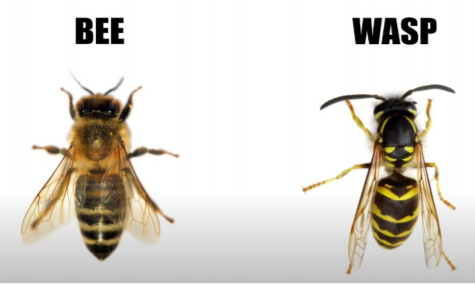
Bees are often confused with wasps because they have a similar shape, Both are flying, stinging insects that are part of the same family. Spotting and knowing the difference between the two is important for getting control of these stinging pests. It would be very difficult to distinguish between bees and wasps with human eyes.

So deep learning can be used to distinguish bees from wasps, the algorithm can also be used to check whether a image has a bee or not. A dataset is available in Kaggle website, that has around 11500 images (including training, validation, test images). Also a CSV file is available with labels for each image.

Importing all the required libraries:

In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.layers as layers
import tensorflow.keras.models as models
import tensorflow.keras.optimizers as optimizers
import tensorflow.keras.losses as losses
import tensorflow.keras.callbacks as callbacks
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
#from keras.optimizers import Adam

In [2]:
DATASET_PATH = "../kaggle_bee_vs_wasp"

label_csv = os.path.join(DATASET_PATH, 'labels.csv')

# Data exploration

In [3]:
label_df = pd.read_csv(label_csv)
label_df.head(10)

,id,path,is_bee,is_wasp,is_otherinsect,is_other,photo_quality,is_validation,is_final_validation,label
0,1,bee1\10007154554_026417cfd0_n.jpg,1,0,0,0,1,0,0,bee
1,2,bee1\10024864894_6dc54d4b34_n.jpg,1,0,0,0,1,0,1,bee
2,3,bee1\10092043833_7306dfd1f0_n.jpg,1,0,0,0,1,1,0,bee
3,4,bee1\1011948979_fc3637e779_w.jpg,1,0,0,0,1,0,1,bee
4,5,bee1\10128235063_dca17db76c_n.jpg,1,0,0,0,1,0,0,bee
5,6,bee1\10130729734_f68738333e_w.jpg,1,0,0,0,1,0,0,bee
6,7,bee1\10166485783_9cd6706c72_n.jpg,1,0,0,0,1,0,0,bee
7,8,bee1\10179824_84803290ac_m.jpg,1,0,0,0,1,0,0,bee
8,9,bee1\10197482094_0176d1bacb_n.jpg,1,0,0,0,1,0,0,bee
9,10,bee1\10242298546_aac12f5223_n.jpg,1,0,0,0,1,0,0,bee


# labels.csv, columns description :

id - ordinal - unique index

path - string - relative path to the photo, including extension

is_bee - nominal - 1 if there is a bee in the photo

is_wasp - nominal - 1 if there is a wasp in the photo

is_otherinsect - nominal - 1 if there is other insect prominently in the centre of the photo, but it is not a wasp and not a bee. It might be a fly, but there are other things there too, like beetles

is_other - random photos not containing any insects

photo_quality - 1 for photos where I have very high confidence that it is bee, wasp, or other. 0 for photos of generally low quality or where I am not very confident that it is - what it says it is. 

is_validation -  for your training validation, 

is_final_validation - testing set, to compute  final score. 

checking if dataset has any missing value:

In [4]:
print('Number of null values')
label_df.isnull().sum()

Number of null values


id                     0
path                   0
is_bee                 0
is_wasp                0
is_otherinsect         0
is_other               0
photo_quality          0
is_validation          0
is_final_validation    0
label                  0
dtype: int64

Before get some intuition about data, let's generate new column which can help us to quickly know that image is train/validation/test From the description we know that validation image is declared in is_validation and test belongs to is_final_validation

In [5]:
def set_train_type(row):
    if row['is_validation'] == 0 and row['is_final_validation'] == 0:
        return 'train'
    if row['is_validation'] == 1:
        return 'validation'
    return 'test'

label_df['type'] = label_df.apply(set_train_type, axis=1)
print('Number values of each type')
label_df['type'].value_counts()

Number values of each type


train         7939
test          1763
validation    1719
Name: type, dtype: int64

In [6]:
def display_img(row, pos):
    #Because path use back slash which is 
    #not compatible for both windows nor linux environment
    # first replace back slash with forward slash
    fn = row['path'].replace('\\', os.sep)
    fn = os.path.join(DATASET_PATH, fn)
    #Read image from path
    img = cv2.imread(fn)
    #Resize all images with the same size
    img = cv2.resize(img, (128, 128))
    #Set RGB color for image
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    #Display image, and set title
    plt.subplot(2, 3, pos)
    plt.imshow(img)
    plt.title(row['label'])
    #Remove ticks
    plt.xticks([])
    plt.yticks([])

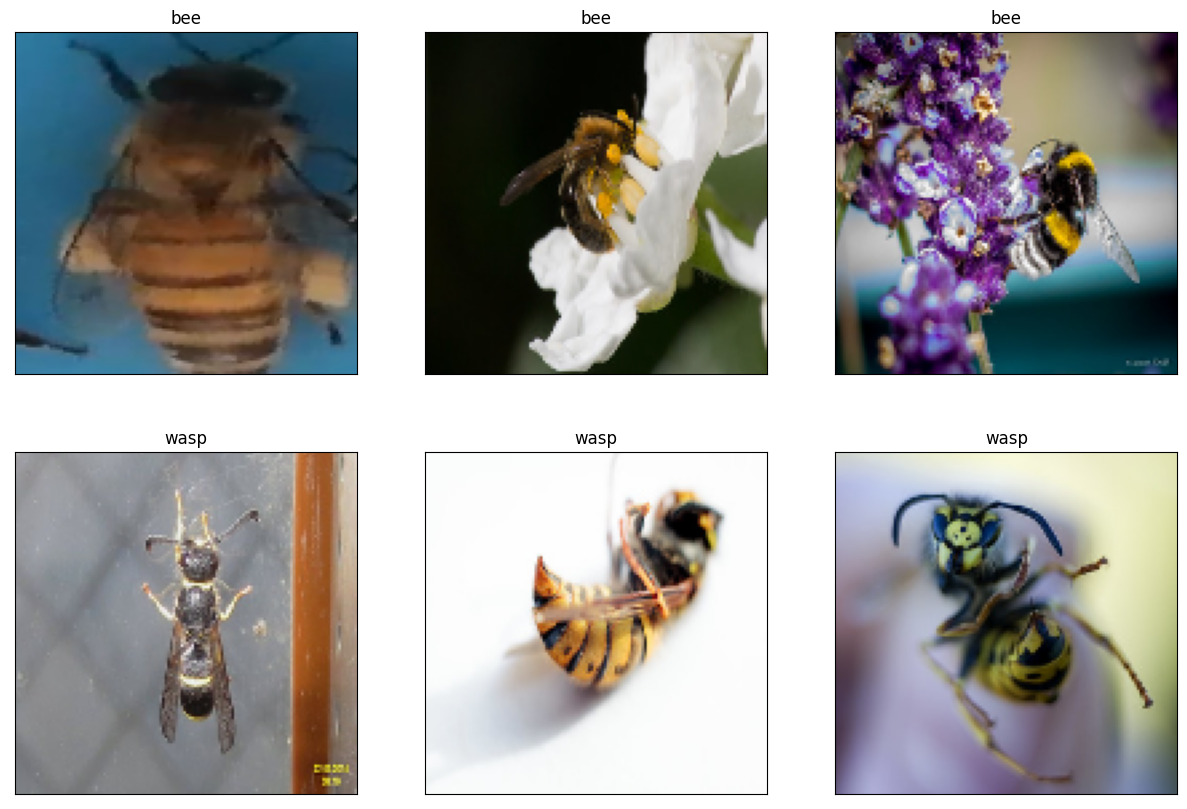

In [7]:
bee = label_df[label_df["label"] == 'bee'].sample(3, random_state=42)
wasp = label_df[label_df["label"] == 'wasp'].sample(3, random_state=42)


plt.figure(figsize=(15,10))
pos = 1
# Display bee
for idx, row in bee.iterrows():
    display_img(row, pos)
    pos += 1
# Display wasp    
for idx, row in wasp.iterrows():
    display_img(row, pos)
    pos += 1

    
plt.show()

In [8]:
label_df.head(10)

,id,path,is_bee,is_wasp,is_otherinsect,is_other,photo_quality,is_validation,is_final_validation,label,type
0,1,bee1\10007154554_026417cfd0_n.jpg,1,0,0,0,1,0,0,bee,train
1,2,bee1\10024864894_6dc54d4b34_n.jpg,1,0,0,0,1,0,1,bee,test
2,3,bee1\10092043833_7306dfd1f0_n.jpg,1,0,0,0,1,1,0,bee,validation
3,4,bee1\1011948979_fc3637e779_w.jpg,1,0,0,0,1,0,1,bee,test
4,5,bee1\10128235063_dca17db76c_n.jpg,1,0,0,0,1,0,0,bee,train
5,6,bee1\10130729734_f68738333e_w.jpg,1,0,0,0,1,0,0,bee,train
6,7,bee1\10166485783_9cd6706c72_n.jpg,1,0,0,0,1,0,0,bee,train
7,8,bee1\10179824_84803290ac_m.jpg,1,0,0,0,1,0,0,bee,train
8,9,bee1\10197482094_0176d1bacb_n.jpg,1,0,0,0,1,0,0,bee,train
9,10,bee1\10242298546_aac12f5223_n.jpg,1,0,0,0,1,0,0,bee,train


# Data preparation

In [9]:
label_df['path'] = label_df['path'].str.replace('\\', "/")
label_df['path'].head()

C:\ProgramData\Anaconda3\envs\tgpu\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  """Entry point for launching an IPython kernel.


0    bee1/10007154554_026417cfd0_n.jpg
1    bee1/10024864894_6dc54d4b34_n.jpg
2    bee1/10092043833_7306dfd1f0_n.jpg
3     bee1/1011948979_fc3637e779_w.jpg
4    bee1/10128235063_dca17db76c_n.jpg
Name: path, dtype: object

In [10]:
train_df = label_df[label_df['type'] == 'train']
valid_df = label_df[label_df['type'] == 'validation']
test_df = label_df[label_df['type'] == 'test']

In [11]:
TARGET_SIZE = (128, 128)
SEED = 42

In [12]:
#same seed is used for all train,validation and test generator.

datagen = keras.preprocessing.image.ImageDataGenerator(rescale=1./255.)

train_datagen = datagen.flow_from_dataframe(train_df, 
                                            directory=DATASET_PATH, 
                                            x_col='path', 
                                            y_col='label',
                                            target_size=TARGET_SIZE,
                                            seed=42
                                           ) 

valid_datagen = datagen.flow_from_dataframe(valid_df,
                                            directory=DATASET_PATH, 
                                            x_col='path', 
                                            y_col='label',
                                            target_size=TARGET_SIZE,
                                            seed=42
                                           ) 

test_datagen = datagen.flow_from_dataframe(test_df, 
                                           directory=DATASET_PATH, 
                                           x_col='path', 
                                           y_col='label',
                                           target_size=TARGET_SIZE,
                                           seed=42
                                           )

Found 7939 validated image filenames belonging to 4 classes.
Found 1719 validated image filenames belonging to 4 classes.
Found 1763 validated image filenames belonging to 4 classes.


In [13]:
n_class = len(label_df['label'].unique())

# Train and evaluate

Used resnet50 as pretrain model to apply transfer learning


In [14]:
resnet50 = keras.applications.ResNet50(include_top=False, input_shape=(128, 128, 3))
# transfer learning using Resnet50 gave better result than doing it from scratch and with comapritively less number of epochs.

In [15]:
from tensorflow.keras.initializers import RandomNormal, Constant

model = models.Sequential([
    resnet50,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.3),
    layers.Dense(n_class, activation='softmax')
])

model.compile(optimizer=optimizers.Adam(learning_rate=0.0001),
              loss=losses.BinaryCrossentropy(),
              metrics=['accuracy']
             )
early_stopping = callbacks.EarlyStopping(patience=5, restore_best_weights=True)

history = model.fit(train_datagen, 
          validation_data=valid_datagen, 
          callbacks=[early_stopping],
          batch_size=16,
          epochs=50,
         )

Epoch 1/50
249/249 [==============================] - 46s 155ms/step - loss: 0.2102 - accuracy: 0.8393 - val_loss: 0.6079 - val_accuracy: 0.4363
Epoch 2/50
249/249 [==============================] - 37s 147ms/step - loss: 0.0689 - accuracy: 0.9535 - val_loss: 0.8086 - val_accuracy: 0.4468
Epoch 3/50
249/249 [==============================] - 37s 148ms/step - loss: 0.0314 - accuracy: 0.9815 - val_loss: 0.5260 - val_accuracy: 0.6579
Epoch 4/50
249/249 [==============================] - 37s 147ms/step - loss: 0.0279 - accuracy: 0.9850 - val_loss: 0.3587 - val_accuracy: 0.8435
Epoch 5/50
249/249 [==============================] - 37s 148ms/step - loss: 0.0312 - accuracy: 0.9830 - val_loss: 0.1980 - val_accuracy: 0.8970
Epoch 6/50
249/249 [==============================] - 37s 147ms/step - loss: 0.0254 - accuracy: 0.9846 - val_loss: 0.1638 - val_accuracy: 0.9174
Epoch 7/50
249/249 [==============================] - 37s 147ms/step - loss: 0.0287 - accuracy: 0.9838 - val_loss: 0.1770 - val_ac

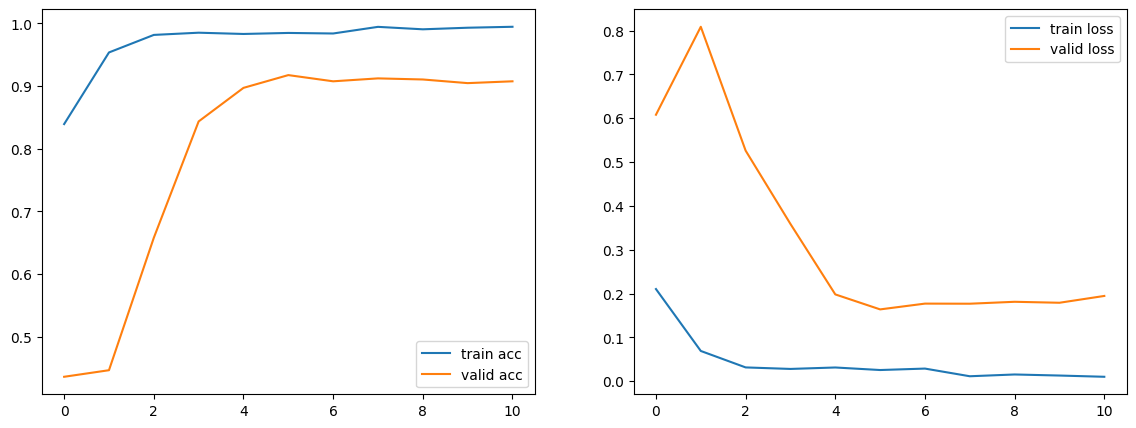

In [16]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(14,5))
plt.subplot(1, 2, 1)
plt.plot(acc, label='train acc')
plt.plot(val_acc, label='valid acc')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(loss, label='train loss')
plt.plot(val_loss, label='valid loss')
plt.legend()

plt.show()

In [17]:
test_loss, test_acc = model.evaluate(test_datagen, verbose=2)
print("Test accuracy:", test_acc)

56/56 - 3s - loss: 0.1599 - accuracy: 0.9104
Test accuracy: 0.9103800058364868
